Definimos la función likelihood

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import scipy.stats as st
from scipy.optimize import minimize
import math
from multiprocessing import Pool
import emcee

os.environ["OMP_NUM_THREADS"] = "1"

In [17]:
# Parámetros del modelo 
Omega_r0 = 0.0
Omega_m0 = 0.30
Omega_l0 = 0.70
h0 = 70 # km / s * Mpc
P = 300 #Número de valores de redshift

Leemos los datos a analizar

In [4]:
valores_z = np.loadtxt('Datos_Mock_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.csv', delimiter = ',', usecols = 0)
distancias = np.loadtxt('Datos_Mock_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.csv', delimiter = ',', usecols = 1)
errores = np.loadtxt('Datos_Mock_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.csv', delimiter = ',', usecols = 2)

Definimos el modelo que usamos

In [5]:
def Omega_k(Omega_m0, Omega_l0, Omega_r0):
    Omega_k0 = 1 - Omega_m0 - Omega_l0 - Omega_r0
    return Omega_k0

def E(x, Omega_m0):
    Omega_r0 = 0
    omega_l0 = Omega_m0 - 1    
    return np.sqrt(Omega_m0*(1+x)**3 + Omega_l0)

In [6]:
def IntFunct(x, Omega_m0):
    return E(x, Omega_m0)**(-1)

def integral(z, Omega_m0):
    return integrate.quad(IntFunct,0, z, args=(Omega_m0),epsabs=1.49e-4, epsrel=1.49e-03,full_output = 1)[0]

Función que calcula la distancia de luminosidad, 

$$ d_A=\frac{r_1}{1+z}=\frac{c}{\sqrt{|\Omega_{k, 0}|}H_0(1+z)}S_k\left(\sqrt{|\Omega_{k, 0}}|\int_0^z\frac{dz}{E(z)}  \right) $$ 

donde 

$$ S_k(x)= \begin{cases}
    \sin(x), \hspace{0.5cm} k>0\\
    x, \hspace{1.35cm} k = 0\\
    \sinh(x), \hspace{0.35cm} k <0
    \end{cases} $$

In [7]:
def distancia_luminosidad(z, h0, Omega_m0):
    
    c = 3 * 10**5 # km / s
    intl = integral(z, Omega_m0) 
    d_L = c * (1 + z) * intl / h0 # solo el caso plano
    return d_L

distancia_luminosidad_vec = np.vectorize(distancia_luminosidad)

Definimos la función likelihood

In [28]:
def log_likelihood(theta, z, distancia, yerr):
    h0, Omega_m0 = theta # Parámetros a minimizar
    Omega_l0 = 1 - Omega_m0
    Omega_r0 = 0
    model = distancia_luminosidad_vec(z, h0, Omega_m0)
    sigma2 = np.array(yerr)**2
    return -0.5 * np.sum((distancia - model) ** 2 / sigma2)

Definimos el prior.

$$
p(H_0)=
\begin{cases}
1, \text{ if } 50<H_0<100\\
0, \text{ otherwise}
\end{cases}
$$
$$
p(\Omega_m)=
\begin{cases}
1, \text{ if } 0<\Omega_m<1\\
0, \text{ otherwise}
\end{cases}
$$
$$
p(\Omega_r)=
0
$$
$$
\Omega_k = 1 - \Omega_m - \Omega_\lambda - \Omega_r
$$

In [29]:
def log_prior(theta):
    h0, Omega_m0 = theta # Parámetros a minimizar
    if 50< h0 < 100 and 0 < Omega_m0 < 1: # and and 0.0 < Omega_m0+Omega_l0+Omega_k(Omega_m0, Omega_l0, Omega_r0) <= 1.0
        return 0.0
    return -np.inf

def condition(theta, z):
    H, Omega_m0 = theta
    omega_l0 = 1 - Omega_m0
    z_max = np.max(z)
    result = Omega_m0*(1+z_max)**3  + Omega_k(Omega_m0, Omega_l0, Omega_r0)*(1+z_max)**2 + Omega_l0
    if result < 0:
        return -np.inf
    return result

Combinamos ahora el prior con la función likelihood para dar la fución de probabilidad (el posterior salvo una constante)

In [30]:
def log_probability(theta, valores_z, distancia, error):
    if not np.isfinite(log_prior(theta)):
        lp = -np.inf
        return lp
    if not np.isfinite(condition(theta, valores_z)):
        lp = -np.inf
        return lp
    lp = 0.0
    Likelihood = log_likelihood(theta, valores_z, distancia, error) +lp
    return Likelihood # Si el valor de lp es finito, contruimos la funcion probabilidad
    

In [31]:
max_n = 10000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

h0_random = np.random.uniform(50, 100, 32)
omega_m_random = np.random.uniform(0, 1, 32)
pos = []
pos = np.column_stack((h0_random, omega_m_random)) # Escribe los 2 vectores como columnas
nwalkers, ndim = pos.shape  # nwalker y ndim toma el valor del número de filas y el número de columnas del vector "pos", respectivamente.



with Pool(processes=6) as pool:
    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(valores_z, distancias, errores))
    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
        # Only check convergence every 100 steps
        if sampler.iteration % 100:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau
        n = 100 * np.arange(1, index + 1)
        y = autocorr[:index]
        plt.plot(n, n / 100.0, "--k")
        plt.plot(n, y)
        plt.xlim(0, n.max())
        plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
        plt.xlabel("number of steps")
        plt.ylabel(r"mean $\hat{\tau}$")
        file_name_fig = 'autocorrelation.png'
        plt.savefig(file_name_fig)
        plt.close()

 42%|████▏     | 4200/10000 [1:01:14<1:24:34,  1.14it/s]


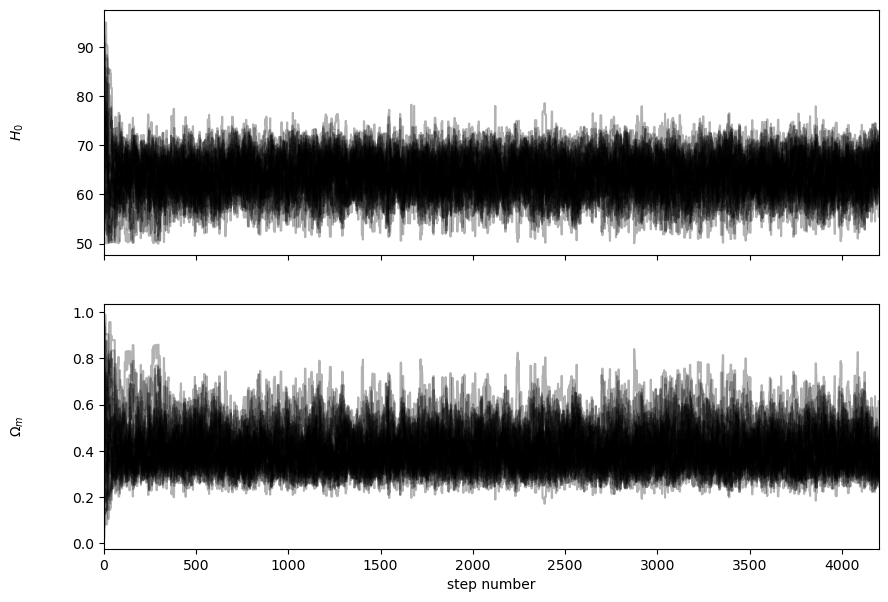

In [32]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$H_0$", "$\Omega_m$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [38]:
tau = sampler.get_autocorr_time()  # autocorrelation
print(tau)
print("-----")
burnin = int(2 * np.max(tau))  # burn in phase
thin = int(0.5 * np.min(tau))  #
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
np.savetxt('flat_samples_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.csv', flat_samples, delimiter = ',')

print(flat_samples)

[39.99150343 41.3521342 ]
-----
[[64.57951818  0.38095973]
 [59.56015682  0.53052963]
 [64.77910843  0.38936487]
 ...
 [60.06057607  0.48243426]
 [65.50974904  0.34990534]
 [68.1024541   0.3230234 ]]


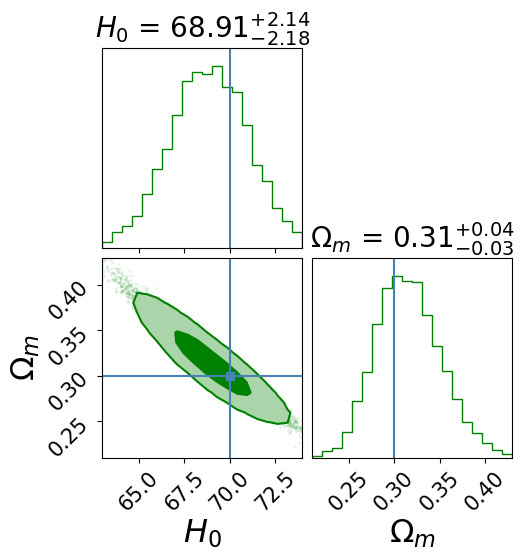

In [23]:
import corner
# Parámetros del modelo
labels = ["$H_0$", "$\Omega_m$"]
flat_samples = np.genfromtxt('flat_samples_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.csv', delimiter = ",")

fig = corner.corner(flat_samples, labels=labels,fill_contours=True,bins=20, color='green', show_titles=True,smooth=1.0, 
                        label_kwargs={"fontsize": 23},title_kwargs={"fontsize": 20}, tick_kwargs={"fontsize": 15},
                        levels=(1-np.exp(-0.5),1-np.exp(-2.0)), truths =[h0, Omega_m0], range = ((63, 74), (0.21, 0.43)))
fontsize = 15
for ax in fig.get_axes():
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
fig.savefig('Datos_Mock_Flat_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.pdf')


In [42]:
sigma_h0 = np.std(flat_samples[:, 0])
print(sigma_h0)

sigma_Omega_m0 = np.std(flat_samples[:, 1])
print(sigma_Omega_m0)

3.966092752168072
0.0872092108706205


Sacamos los resultados con sus respectivos errores

In [43]:
from IPython.display import display, Math

results = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    append = [mcmc[1], q[0], q[1]]
    results.append(append)
    display(Math(txt))
np.savetxt('Resultados_P-' + str(P) + '_H0-' + str(h0) + '_Omega_r-' + str(Omega_r0) + '_Omega_m-' + str(Omega_m0) + '_Omega_l-' + str(Omega_l0) + '.csv', results, delimiter=',')
    
    

<IPython.core.display.Math object>

<IPython.core.display.Math object>